# Classification Homework Section 1: Simulated Data

In this notebook, we will practice using several common classification techniques for binary data using [sklearn](http://scikit-learn.org).  You should use this notebook to gain some intuition about how each of these classification methods work, and how algorithm parameters affect classification performance.  

Feel free to edit this notebook, but note that you will be using this notebook to solve your homework problems.



This notebook is accompanied by two pickle files containing artificial datasets:

- `data_multigauss.p` <br>
- `data_spiral.p`

The data contained in these files has already been split into training and validation sets.  The files contain `(X_train, X_val, y_train, y_val)`  as numpy arrays.  

The data inputs `X_train` and `X_val` are 2-dimensional, making them convenient to visualize.  

The data outputs `y_train` and `y_val` contain binary class labels (0,1).

We provide several functions for visualizing the output of your classifiers.  You are encouraged to look at and edit these functions to get more familiar with matplotlib, but they should work without modification.

In [2]:
# import 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

# plot within the notebook
%matplotlib inline

# some plotting configurations
matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 16})

## Load and Visualize Data
Here we will visualize the training data.  Note that the data is noisy and is *not* linearly seperable.

Your options for `datafile` are `'data_multigauss.p'` and `'data_spiral.p'`.

In [3]:
# Load the data
datafile = 'data_multigauss.p'
X_train, X_val, y_train, y_val = pickle.load( open(datafile , 'rb' ) )

feature_names = ['x_{}'.format(k) for k in range(len(X_train[0,:]))]

# Store training and validation data in pandas dataframes
data_train = pd.DataFrame(np.c_[X_train, y_train],columns= np.append(feature_names, ['y']))
data_val = pd.DataFrame(np.c_[X_val, y_val],columns= np.append(feature_names, ['y']))

Text(0.5, 1.0, 'Training Data')

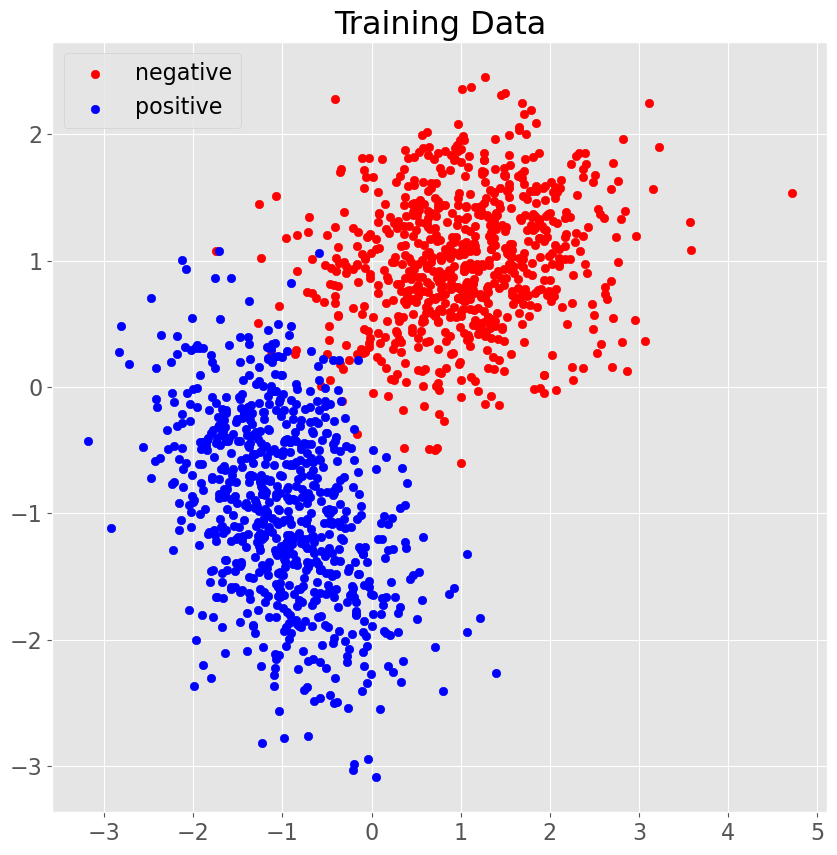

In [4]:
# Plot the training data

Xneg = data_train[data_train['y']==0]
Xpos = data_train[data_train['y']==1]

plt.figure(figsize=(10, 10))
plt.scatter(Xneg['x_0'],Xneg['x_1'],color='r',label='negative')
plt.scatter(Xpos['x_0'],Xpos['x_1'],color='b',label='positive')
plt.legend()
plt.title('Training Data')

## Functions for training a generic sklearn classifier and plotting the results

Here we provide some functions you may find helpful for training, evaluating and visualizing your classifiers.  You are encouraged to look at these functions to understand what they're doing, but they should work without modification.

The function `train_and_plot()` takes in a sklearn classifier object, fits the model to training data, and evaluates the model on validation data.  This particular function assumes 2D data (defined by features x0_col and x1_col) and binary class labels (y = 0 or 1). 

The function `plot_data_class()` will create a 2D plot of data that has gone through a classifier.  If the original data (and therefore the classifier decision boundary) is also in 2D, it will also plot the decision boundary.

In [75]:
def plot_data_class(data, x0_col=None, x1_col=None, xx=None, yy=None, Z=None, title='Classification Results'):
    """
    Plot the classification results on data and the decision boundary 
    (Decision boundary will only be plotted if data is 2D)
    
    
    Parameters
    ----------
    data :  pandas dataframe with columns = 'x_0', 'x_1', ... 'x_n', 'y', 'y_predict'
            each row corresponds to a single data point
                column 'x_n'       : nth feature 
                column 'y'         : true data label
                column 'y_predict' : predicted data label
                
    x0_col: string corresponding to the x-axis feature
    x1_col: string corresponding to the y-axis feature
    
    xx :    nd-array containing x-axis values for contour plot, must correspond to x0_col feature in data
    yy :    nd-array containing y-axis values for contour plot, must correspond to x1_col feature in data
            xx, yy = np.meshgrid()
             
    Z :     nd-array corresponding to classifier predictions of (xx,yy)
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
    
    title :  title of the plot (optional, default: 'Classification Results')
    
    Returns
    -------
    None
    
    """
    
    # data features (exclude labels and predicted labels, if stored in the dataframe)
    features = data.columns.difference(['y','y_predict'])
    
    # If no features are specified, use the first two
    if x0_col is None: x0_col = features[0]
    if x1_col is None: x1_col = features[1]
    
    # Separate the data into correctly and incorrectly classified sets
    TP = data[(data['y']==1) & (data['y_predict']==1)]   # true positives
    FP = data[(data['y']==0) & (data['y_predict']==1)]   # false positives (type I error)
    TN = data[(data['y']==0) & (data['y_predict']==0)]   # true negatives
    FN = data[(data['y']==1) & (data['y_predict']==0)]   # false negatives (type II error)

    # Plot the contours if we're able (will pass if xx, yy, or Z are None)
    try: plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu,alpha=0.5)
    except: pass
        
    # Plot the datapoints in 2D (actual data may be in higher dimension)
    plt.scatter(TP[x0_col],TP[x1_col],marker='.',c='b',label='TP')
    plt.scatter(TN[x0_col],TN[x1_col],marker='.',c='r',label='TN')
    plt.scatter(FN[x0_col],FN[x1_col],marker='x',c='b',s=100,label='FN')
    plt.scatter(FP[x0_col],FP[x1_col],marker='x',c='r',s=100,label='FP')
    
    plt.xlabel(x0_col)
    plt.ylabel(x1_col)
    plt.legend()
    plt.title(title)
    

In [76]:
def train_and_plot(clf, data_train, data_test, plot_bool=True, x0_col=None, x1_col=None):
    
    """
    Train a classifier, evaluate, and plot
    
    Parameters
    ----------
    
    clf  :  a sklearn classifier object (e.g., sklearn.neighbors)
    
    data_train : pandas dataframe containing 2D training data
                 each row corresponds to a single data point
                        column 'y' : true label
                        
    data_test :  pandas dataframe containing 2D test data
                 each row corresponds to a single data point
                        column 'y' : true label
                        
    plot_bool :  boolean (default: True)
                 set to False to suppress plots
                 
    x0_col :     name of first feature to plot, corresponding to a column in data_train
                 if x0_col is not specified, the first column is used
                 
    x1_col :     name of second feature to plot, corresponding to a column in data_train
                 if x1_col is not specified, the second column is used
                 
                  
    Returns
    -------
    acc :   dictionary
                'acc_train' : training accuracy
                'acc_test'  : testing accuracy
    
    """
    
    
    # Define X (exclude labels and predicted labels, if stored in the dataframe)
    X_train = data_train[data_train.columns.difference(['y','y_predict'])]
    X_test = data_test[data_test.columns.difference(['y','y_predict'])]
    
    # Train (fit) the classifier to training data    
    clf = clf.fit(X_train.values,data_train['y'].values)

    # Apply the classifier to train and test data
    data_train['y_predict'] = clf.predict(X_train.values)
    data_test['y_predict'] = clf.predict(X_test.values)
    
    # Calculate train and test accuracy
    acc_train = clf.score(X_train.values,data_train['y'].values)
    acc_test = clf.score(X_test.values,data_test['y'].values)
    

    # Plot the classification
    if plot_bool:

        if x0_col is None: x0_col = X_train.columns[0]
        if x1_col is None: x1_col = X_train.columns[1]
            
            
        # If we only have 2 features, we can make a contour plot by evaluating over a grid!  Otherwise, skip.
        if X_train.shape[1] == 2:
            
            x_min = min(X_train[x0_col].min(),X_test[x0_col].min()) - 0.2
            x_max = max(X_train[x0_col].max(),X_test[x0_col].max()) + 0.2
            y_min = min(X_train[x1_col].min(),X_test[x1_col].min()) - 0.2
            y_max = max(X_train[x1_col].max(),X_test[x1_col].max()) + 0.2

            plot_step_x = (x_max-x_min)/100
            plot_step_y = (y_max-y_min)/100
            xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step_x),np.arange(y_min, y_max, plot_step_y))

            # Predict on grid for contour plot
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
        else:
            xx,yy,Z=None,None,None

        # Plot
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plot_data_class(data_train, x0_col, x1_col, xx, yy, Z, title='Train Data, acc={:0.3f}'.format(acc_train))
        plt.subplot(1, 2, 2)
        plot_data_class(data_test, x0_col, x1_col, xx, yy, Z, title='Test Data, acc={:0.3f}'.format(acc_test))
        plt.show()

            
        
    return {'acc_train':acc_train, 'acc_test':acc_test}

# Train a Naive Bayes Classifier
Refer to scikit-learn documentation for details: [Gaussian Naive Bayes Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

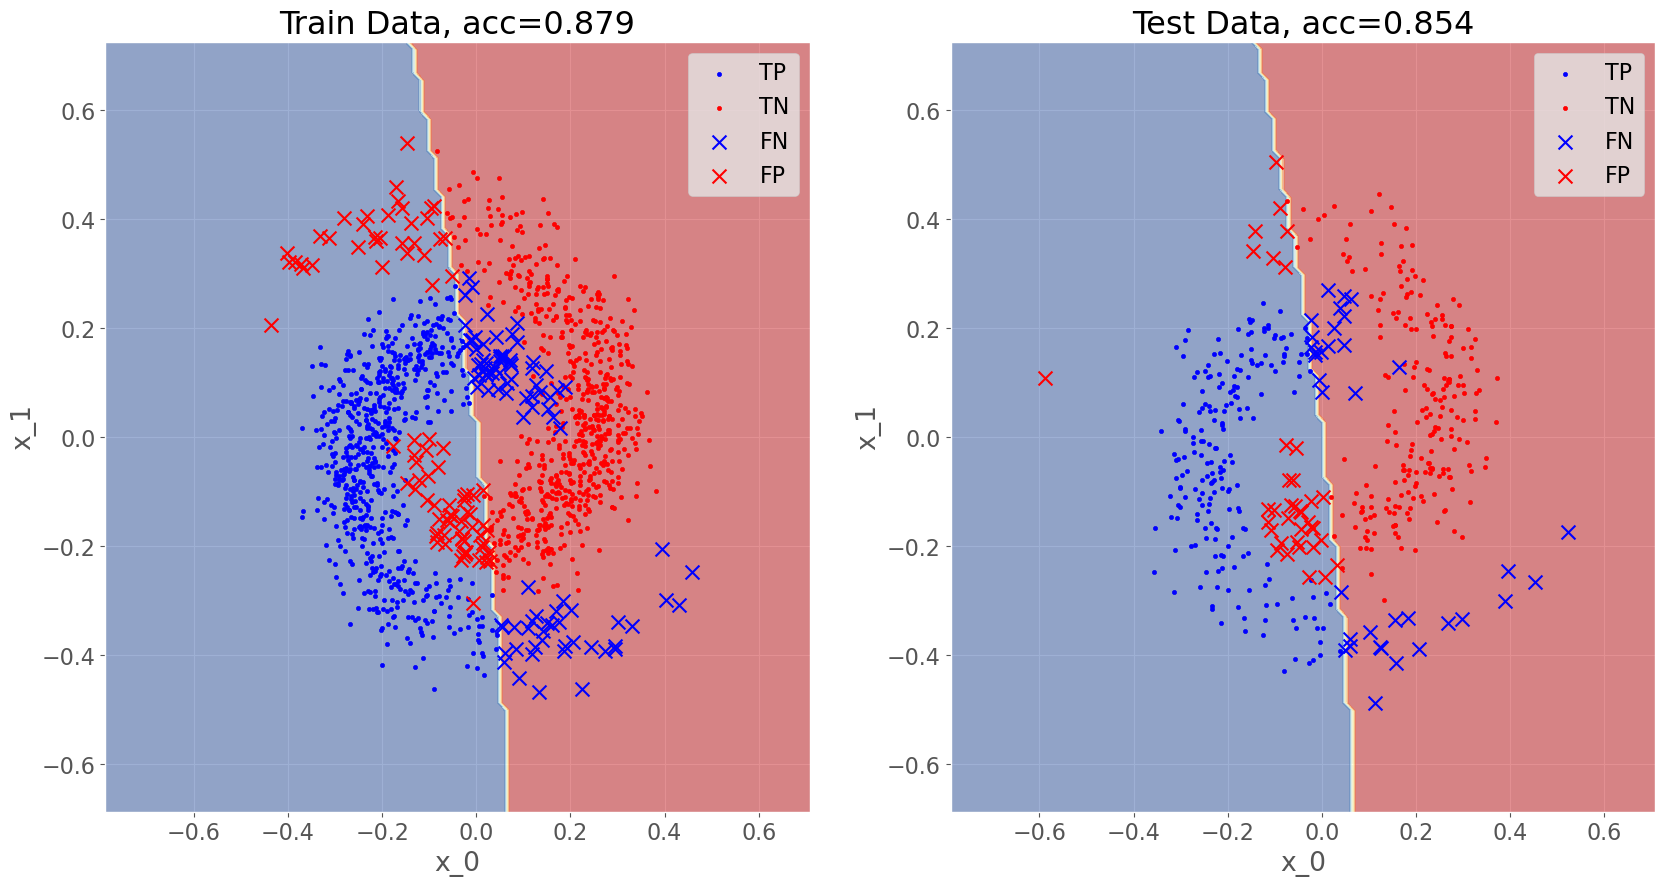

Training Accuracy: 0.879
Testing Accuracy:  0.854


In [77]:
from sklearn import naive_bayes
    
# Define the classifier
priors=None
clf = naive_bayes.GaussianNB(priors=priors)


# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

### HW 1.1: Naive Bayes Priors
If you do not define the prior for the Naive Bayes classifier (`priors=None`), what is the calculated probability of the negative class?

> *Hint*: use `clf.class_prior_[0]` to see the negative class prior or `clf.class_prior_[1]` to see the positive class prior

In [79]:
print(clf.class_prior_[0])




0.49533333333333335


### HW 1.2: Naive Bayes Training Accuracy
What is the value of `prior_0` that results in the highest accuracy on the **training** data for the Naive Bayes classifier?


> *Note*: Test priors in `np.linspace(0.1,0.9,num=9)`.<br>
> *Note*: Make sure to report the value of parameter `prior_0`, not the accuracy

In [80]:
for prior_0 in np.linspace(0.1,0.9,num=9):
    print(prior_0)
    test = naive_bayes.GaussianNB(priors = [prior_0, 1-prior_0])
    test1 = train_and_plot(test, data_train, data_val, plot_bool = False)
    print("accuracy for " + str(prior_0) + ": " + str(test1['acc_train']))
    



0.1
accuracy for 0.1: 0.8213333333333334
0.2
accuracy for 0.2: 0.8593333333333333
0.30000000000000004
accuracy for 0.30000000000000004: 0.87
0.4
accuracy for 0.4: 0.874
0.5
accuracy for 0.5: 0.8793333333333333
0.6
accuracy for 0.6: 0.8753333333333333
0.7000000000000001
accuracy for 0.7000000000000001: 0.862
0.8
accuracy for 0.8: 0.8486666666666667
0.9
accuracy for 0.9: 0.8213333333333334


### HW 1.3: Naive Bayes Test Accuracy
What is the **test** accuracy achieved by the Naive Bayes Classifier using the value of `prior_0` from the previous question?

> *Note*: `acc = train_and_plot(...)` returns `acc`, a dictionary containing the training and testing accuracy on the data sets provided.  Try `print(acc)` to print the contents of this dictionary, or `print(acc['acc_test'])` to print only the test accuracy.

In [82]:
test = naive_bayes.GaussianNB(priors = [0.5,0.5]) 
test1 = train_and_plot(test, data_train, data_val, plot_bool = False)
print(test1['acc_test'])



0.856


# Train a k-NN Classifier
Refer to scikit-learn documentation for details: [Nearest Neighbors Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

### HW 1.4: Nearest Neighbors
What is the value of `n` that results in the highest accuracy on the **validation** (or test) data for the Nearest Neighbors classifier?
Test `n in range(1,21)`. If there are multiple values of `n` that give the same accuracy, report the smallest `n`.

In [83]:

for n in range(1,21):
    test = neighbors.KNeighborsClassifier(n_neighbors=n)
    test1 = train_and_plot(test, data_train, data_val, plot_bool = False)
    print(n)
    print(test1["acc_test"])




1
0.982
2
0.976
3
0.974
4
0.978
5
0.974
6
0.978
7
0.976
8
0.974
9
0.974
10
0.974
11
0.972
12
0.972
13
0.972
14
0.972
15
0.97
16
0.972
17
0.972
18
0.974
19
0.97
20
0.97


# Train a Decision Tree
Refer to scikit-learn documentation for details: [Decision Tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)


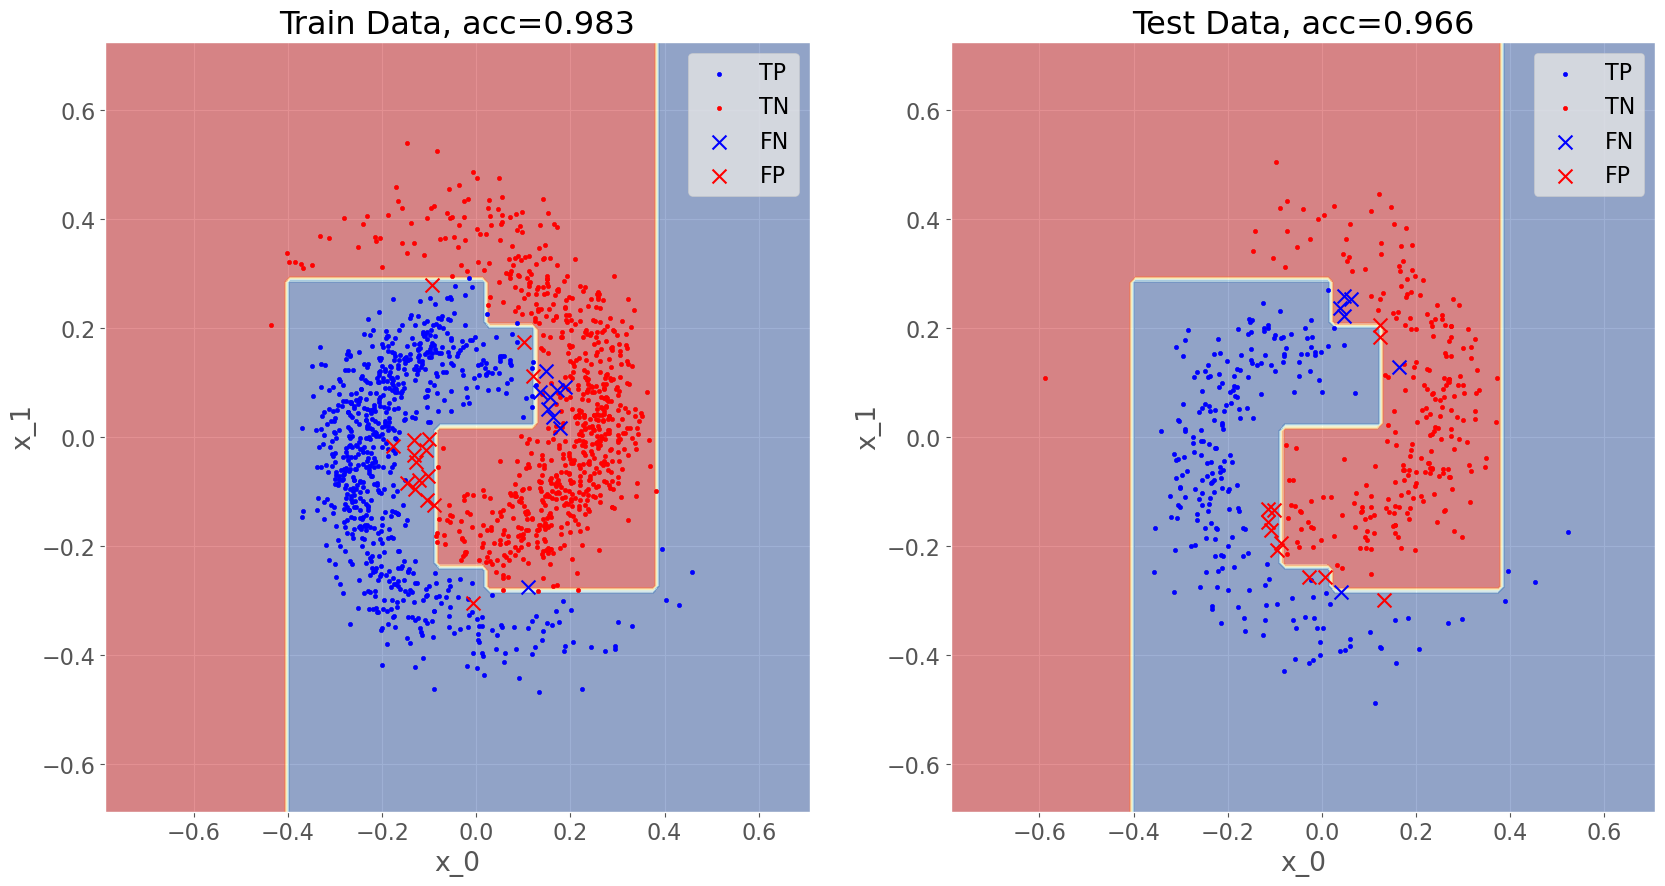

Training Accuracy: 0.983
Testing Accuracy:  0.966


In [84]:
from sklearn import tree

# Define the classifier
max_depth = 5
clf = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=999)

# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

### HW 1.5: Decision Tree Training
What is the value of `max_depth` that results in the highest accuracy on the **training** data for the Decision Tree classifier?

### HW 1.6: Decision Tree Testing
What is the value of `max_depth` that results in the highest accuracy on the **validation** (test) data for the Decision Tree classifier?

> Note: Test `max_depth in range(1,16)`. If there are multiple values of `max_depth` that give the same accuracy, report the smallest `max_depth`.

In [85]:
for max_depth in range(1,16):
    print(max_depth)
    test = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=999)
    test1 = train_and_plot(test, data_train, data_val, plot_bool=False)
    print("training: " + str(test1['acc_train']))
    print("validation: " + str(test1['acc_test']))


1
training: 0.8773333333333333
validation: 0.86
2
training: 0.938
validation: 0.914
3
training: 0.938
validation: 0.914
4
training: 0.9466666666666667
validation: 0.934
5
training: 0.9833333333333333
validation: 0.966
6
training: 0.9846666666666667
validation: 0.97
7
training: 0.994
validation: 0.978
8
training: 0.9953333333333333
validation: 0.978
9
training: 0.9953333333333333
validation: 0.978
10
training: 0.9966666666666667
validation: 0.972
11
training: 0.9973333333333333
validation: 0.972
12
training: 0.9993333333333333
validation: 0.974
13
training: 0.9993333333333333
validation: 0.974
14
training: 1.0
validation: 0.972
15
training: 1.0
validation: 0.972


# Train a Linear Support Vector Machine
Refer to scikit-learn documentation for details: [SVM Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)


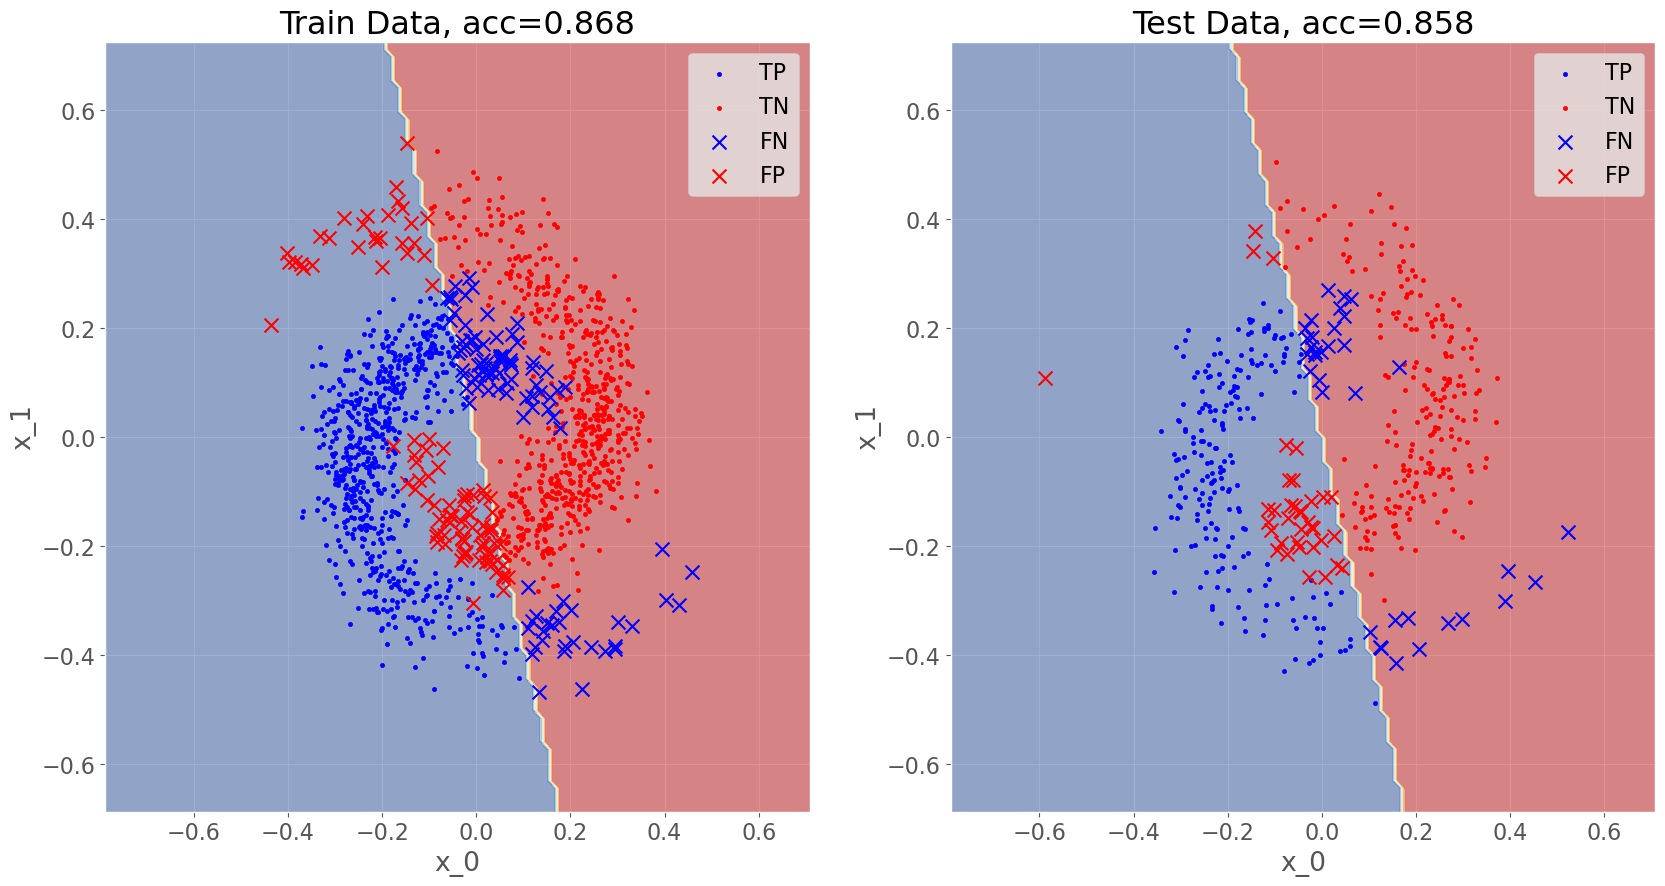

Training Accuracy: 0.868
Testing Accuracy:  0.858


In [86]:
from sklearn import svm

# Define the classifier
C=1.0
clf = svm.LinearSVC(C=C, random_state=999)

# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

# Train a Support Vector Machine with Kernels
Refer to scikit-learn documentation for details: [SVM Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)


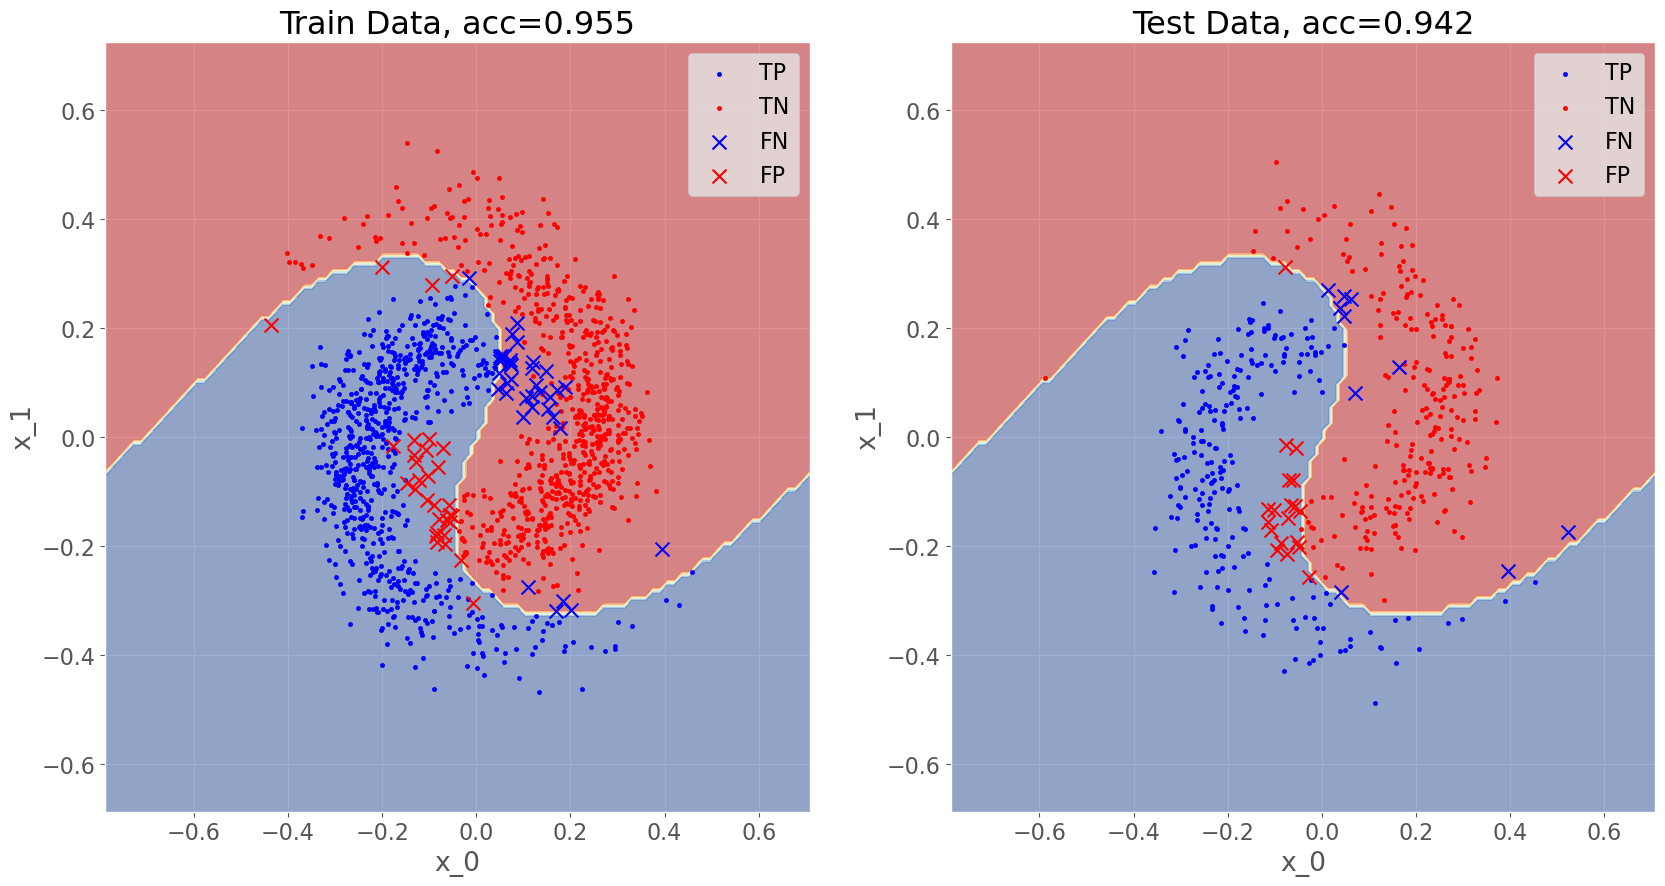

Training Accuracy: 0.955
Testing Accuracy:  0.942


In [92]:
from sklearn import svm

# Classifier parameters 
kernel = 'rbf'
gamma = 3
C = 1.0

# Define the classifier
clf = svm.SVC(kernel=kernel, C=C, gamma=gamma, random_state=999)

# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

### HW 1.7: SVM Training
What is the value of `gamma` that results in the highest accuracy on the **training** data for the SVM classifier using an RBF kernel?

### HW 1.8: SVM Testing
What is the value of `gamma` that results in the highest accuracy on the **validation** (test) data for the SVM classifier using an RBF kernel?

> Test `gamma in range(1,31)`. If there are multiple values of `gamma` that give the same accuracy, report the smallest `gamma`.

In [93]:
for gamma in range(1,31):
    test = svm.SVC(kernel=kernel, C=C, gamma = gamma, random_state=999)
    test1 = train_and_plot(test, data_train, data_val, plot_bool=False)
    print(gamma)
    print(test1['acc_test'])
    print(test1['acc_train'])




1
0.874
0.8873333333333333
2
0.906
0.9253333333333333
3
0.942
0.9546666666666667
4
0.96
0.9653333333333334
5
0.964
0.9706666666666667
6
0.974
0.9746666666666667
7
0.976
0.9753333333333334
8
0.982
0.9746666666666667
9
0.982
0.976
10
0.982
0.9773333333333334
11
0.982
0.9773333333333334
12
0.984
0.9773333333333334
13
0.984
0.978
14
0.982
0.9793333333333333
15
0.982
0.98
16
0.982
0.9813333333333333
17
0.984
0.982
18
0.986
0.982
19
0.986
0.9826666666666667
20
0.986
0.9833333333333333
21
0.986
0.9833333333333333
22
0.988
0.984
23
0.988
0.984
24
0.988
0.984
25
0.986
0.984
26
0.986
0.9853333333333333
27
0.986
0.9853333333333333
28
0.986
0.986
29
0.986
0.986
30
0.986
0.986
